In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-email/spam.csv


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-10-15 21:05:11.661733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760562312.086292      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760562312.200852      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## STEP 1: LOAD & PREPROCESS DATA

In [3]:
DATA_PATH = '/kaggle/input/spam-email/spam.csv'

# Load data
df = pd.read_csv(DATA_PATH, encoding='latin-1')

# Keep only relevant columns
df = df[['Category', 'Message']]
df.columns = ['label', 'message']

# Encode labels: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Columns:", df.columns)
print(df.head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], 
                                                    test_size=0.2, random_state=42)

Columns: Index(['label', 'message'], dtype='object')
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


## STEP 2: TOKENIZATION & SEQUENCING

In [4]:
vocab_size = 10000
max_len = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


## STEP 3: MODEL CREATION

In [5]:
model = Sequential([
    Embedding(vocab_size, 128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

I0000 00:00:1760562332.848790      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760562332.849498      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## STEP 4: CALLBACKS (EarlyStopping & Checkpoint)

In [6]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    'best_spam_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

## STEP 5: TRAIN THE MODEL

In [7]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10


I0000 00:00:1760562339.450220      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8704 - loss: 0.4101
Epoch 1: val_accuracy improved from -inf to 0.96525, saving model to best_spam_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8730 - loss: 0.3986 - val_accuracy: 0.9652 - val_loss: 0.1257
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9805 - loss: 0.0718
Epoch 2: val_accuracy improved from 0.96525 to 0.98206, saving model to best_spam_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9806 - loss: 0.0714 - val_accuracy: 0.9821 - val_loss: 0.0793
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9960 - loss: 0.0169
Epoch 3: val_accuracy did not improve from 0.98206
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9960 - loss: 0.0170 - val_accuracy: 0.9809 - val_loss: 0.0897
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9976 - loss: 0.0124
Epoch 4: val_accuracy did not improve from 0.98206
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/

## STEP 6: EVALUATION

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

✅ Accuracy: 98.92%

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



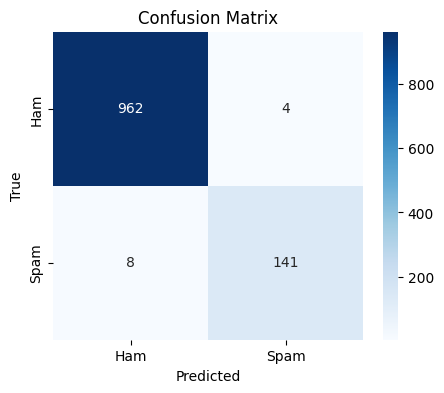

In [8]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## STEP 7: TRAINING VISUALIZATION

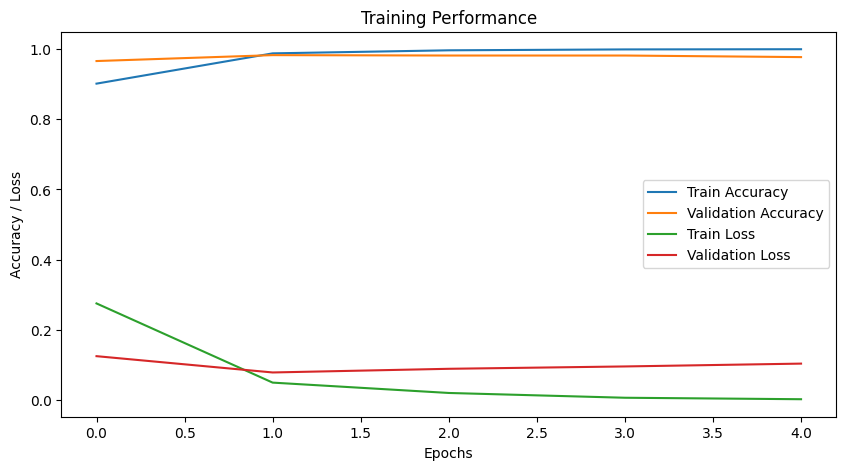


✅ Best model saved as 'best_spam_model.keras'


In [9]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

print("\n✅ Best model saved as 'best_spam_model.keras'")